TU Delft internship of Bordeaux ENSEIRB -MATMECA student Anouchka Desmettre 
Dates: June 1st - August 31st, 2024 

Supervision: D. Lahaye (DIAM - EEMCS Faculty - TU Delft)

# Title: Mathematical modelling and numerical simulation of driving buses and vibrations door   

## 5. Stationary Thin Beam Equation - Biharmonic Equation - Deflection 

### The bi-harmonic equation

The bi-harmonic equation in the context of a non-stationary thin beam typically describes the deflection of the beam (see Sources section 5.5 [1]). It can be expressed as :

$$
\nabla^2 (EI \times \nabla^2 u) = \frac{\partial^2 u}{\partial t^2} + S
$$

In this equation:
- $\nabla^4$ represents the biharmonic operator.
- $u$ denotes the displacement.
- $E$ is the Young's modulus, and $I$ is the moment of inertia of the beam or plate.
- $\frac{\partial^2 u}{\partial t^2}$ is the second derivative of displacement with respect to time, indicating the acceleration.
- $S$ stands for any external source terms or forces acting on the system.

This equation provides a comprehensive model for predicting how beams bend and flex under such forces.

### Stationary behavior and single material

Before addressing the dynamic, non-stationary behavior, we first need to solve the stationary form of the equation in 2D. We also assume that our system is composed of a single material, which allows us to factor out $EI$ from the biharmonic operator $\nabla^2$, which simplifies to:

$$
EI \times \nabla^4 u = S 
$$

This stationary equation describes the beam's deflection under static loads in two dimensions, where time-dependent effects are not considered. Solving this will give us insight into the fundamental bending behavior of the beam under steady-state conditions.

### External source forces

To model a single force acting on the beam, we use a Gaussian function for the source term $S$. This function will have a maximum value $A$ representing the magnitude of the force, a width parameter $\sigma$, and be centered at position $x_0$ on the beam.  

$$
EI \times (\frac{\partial^4 u}{\partial x^4} + 2\frac{\partial^4 u}{\partial x^2 \partial y^2} + \frac{\partial^4 u}{\partial y^4}) = A \exp \left( -\frac{(x - x_0)^2 + (y - y_0)^2)}{2\sigma^2} \right)
$$

This stationary equation describes the beam's deflection under static loads in two dimensions, where time-dependent effects are not considered. Solving this will give us insight into the fundamental bending behavior of the beam under steady-state conditions.

In [2]:
using Plots
using BoundaryValueDiffEq
using OrdinaryDiffEq
using BenchmarkTools

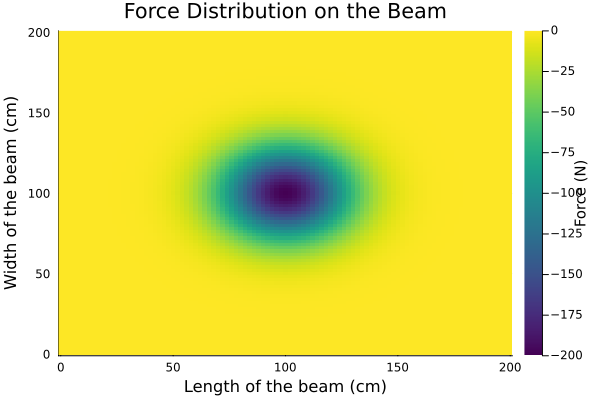

In [3]:
# Parameters
Nx = 100           # Number of segments along the x-axis
Ny = 100           # Number of segments along the y-axis
l = 200.0          # Total length of the domain in both x and y directions (assumed square)
dx = l / Nx        # Distance between adjacent nodes along the x-axis, meaning there is Nx+1 nodes
dy = l / Ny        # Distance between adjacent nodes along the y-axis, meaning there is Ny+1 nodes
E = 1.9 * 10^7     # Modulus of elasticity
I = 117.8          # Moment of inertia
EI = E * I         # Flexural rigidity

# Function to define the 2D source function
function source_function_2d(x, y)
    X0 = 100.0
    Y0 = 100.0
    σ  = 20
    A  = 200.0
    return -A * exp(-((x - X0)^2 + (y - Y0)^2) / (2*σ^2))
end

# Function to generate the source grid in 2D
function source_2d(Nx, Ny)
    X_vect = range(0, stop=l, length=Nx)
    Y_vect = range(0, stop=l, length=Ny)
    f = [source_function_2d(x, y) for y in Y_vect, x in X_vect]
    return X_vect, Y_vect, f
end

# Generate the 2D force distribution
X, Y, force_distribution = source_2d(Nx+1, Ny+1)

# Plotting the 2D force distribution
heatmap(X, Y, force_distribution, xlabel="Length of the beam (cm)", ylabel="Width of the beam (cm)", c=:viridis, colorbar_title="Force (N)", title="Force Distribution on the Beam")


### 5.1 Analytical Reference Solution

The biharmonic equation can be written as :
$$
-\nabla^4 u(\mathbf{x}, \mathbf{x}') = \delta(\mathbf{x} - \mathbf{x}')
$$
In this equation:
- $\nabla^4$ is the biharmonic operator.
- $u(\mathbf{x}, \mathbf{x}')$ is the fundamental solution.
- $\delta(\mathbf{x} - \mathbf{x}')$ is the Dirac delta function, representing a point source of influence at the position $\mathbf{x}'$.

The fundamental solutions vary depending on the dimension of the space in which the equation is solved:

1. **In 2 dimensions (2D)**:
   $$
   u_{\text{2D}}(\mathbf{x}, \mathbf{x}') = -\frac{|\mathbf{x} - \mathbf{x}'|^2}{8\pi} \ln |\mathbf{x} - \mathbf{x}|
   $$

This solution reflects how the beam's deflection behaves at points other than the load. It indicates that as you approach the load point $x'$, the deflection influenced by the logarithm of the distance modulated by the square of the distance might mathematically trend towards zero. This modeling reflects how the deflection amplitude due to bending stresses behaves under theoretical point loads, highlighting localized intensities.

In practical terms, at the exact point of the load, the deflection would be maximal due to the direct impact of the force, contrary to what the logarithmic term might suggest. However, just away from the point, the behavior captured by this solution is indicative of the stress concentration and the rate at which material properties distribute these forces—key information in designing beams for structural integrity.

Therefore, we will not rely on this analytical solution.

Now, let's discuss the shooting method. This method, useful for solving boundary value problems numerically, does not directly yield the previous fundamental solutions of the biharmonic equation which is derived using analytical techniques for a point source in an infinite domain.

However, the shooting method can be employed to determine analytical solutions for specific boundary value problems in finite domains.

### 5.2. Shooting Method Research

1. **What is BoundaryValueDiffEq?** 

BoundaryValueDiffEq is a Julia package specifically designed to solve boundary value problems (BVPs) for ordinary differential equations (ODEs). BVPs require solutions to differential equations where conditions are specified at different points, typically at the domain's boundaries, unlike initial value problems where conditions are only given at the start point.

2. **Role of the Shooting Method in BoundaryValueDiffEq**

The shooting method, implemented in the BoundaryValueDiffEq package, is one approach to solve BVPs. Here's how we proceed:

- Initial Guess: Start with an initial guess for the unknown initial conditions at one boundary.
- Solve Forward: Use an ODE solver to integrate the differential equation from one boundary to the other.
- Adjust Guess: Adjust the initial conditions based on the difference between the computed endpoint and the specified boundary condition at the final boundary.
- Iterate: Repeat the process, refining the initial conditions until the solution converges to satisfy the boundary conditions at both ends.

3. **Limitations of the Shooting Method for Solving PDEs**

Partial differential equations (PDEs), like the biharmonic equation, involve derivatives with respect to more than one independent variable. The complexity of PDEs, including the need to deal with functions of several variables and multiple boundary conditions across different dimensions, makes the shooting method unsuitable.

Transforming a PDE into ODEs using techniques like separation of variables or Fourier expansions could be used. However, the success and feasibility of these methods heavily depend on the specific structure of the equation and the boundary conditions. 

For solving PDEs like the biharmonic equation, other numerical methods such as finite difference, finite element, or spectral methods are typically employed. These methods are designed to handle the multidimensional aspects and the complex boundary conditions of PDEs, providing a more feasible approach for obtaining solutions.

### 5.3 Finite Difference Method on Uniform Spatial Mesh

We will first work on a uniform spatial mesh. Let's remind us the 2D biharmonic equation :
$$
EI \times \left(\frac{\partial^4 u}{\partial x^4} + 2\frac{\partial^4 u}{\partial x^2 \partial y^2} + \frac{\partial^4 u}{\partial y^4}\right) = S(x, y)
$$

#### 5.3.1 Discretization of the Biharmonic Equation

- Discretization of the Biharmonic Operator

For accuracy, the biharmonic equation is discretized using second-order central differences. This involves applying the central difference formula twice to approximate the fourth derivatives in the equation. For $i \in [3, N_x-1]$ and $j \in [3, N_y-1]$:

  $$
  \frac{\partial^4 u}{\partial x^4} \approx \frac{u_{i+2,j} - 4u_{i+1,j} + 6u_{i,j} - 4u_{i-1,j} + u_{i-2,j}}{dx^4}
  $$

  $$
  \frac{\partial^4 u}{\partial y^4} \approx \frac{u_{i,j+2} - 4u_{i,j+1} + 6u_{i,j} - 4u_{i,j-1} + u_{i,j-2}}{dy^4}
  $$

  $$
  \frac{\partial^4 u}{\partial x^2 \partial y^2} \approx \frac{u_{i+1, j+1} - 2u_{i+1, j} + u_{i+1, j-1} - 2u_{i, j+1} + 4u_{i, j} - 2u_{i, j-1} + u_{i-1, j+1} - 2u_{i-1, j} + u_{i-1, j-1}}{dx^2 dy^2}
  $$

Which leads to : 
$$
\frac{EI\times(u_{i+2,j} - 4u_{i+1,j} + 6u_{i,j} - 4u_{i-1,j} + u_{i-2,j})}{dx^4} + 2\frac{EI\times(u_{i+1,j+1} - 2u_{i+1,j} + u_{i+1,j-1} - 2u_{i,j+1} + 4u_{i,j} - 2u_{i,j-1} + u_{i-1,j+1} - 2u_{i-1,j} + u_{i-1,j-1})}{dx^2 dy^2} + \\
\frac{EI\times(u_{i,j+2} - 4u_{i,j+1} + 6u_{i,j} - 4u_{i,j-1} + u_{i,j-2})}{dy^4} = S_{i,j}
$$

Using $\alpha = \frac{EI}{dx^4} = \frac{EI}{dy^4}$ (assuming $dx = dy$ for simplification), the 2D discretized biharmonic equation can be expressed as:

$$
\alpha (u_{i+2,j} - 4u_{i+1,j} + 6u_{i,j} - 4u_{i-1,j} + u_{i-2,j}) + 2\alpha (u_{i+1,j+1} - 2u_{i+1,j} + u_{i+1,j-1} - 2u_{i,j+1} + 4u_{i,j} - 2u_{i,j-1} + u_{i-1,j+1} - 2u_{i-1,j} + u_{i-1,j-1})+ \alpha (u_{i,j+2} - 4u_{i,j+1} + 6u_{i,j} - 4u_{i,j-1} + u_{i,j-2}) = S_{i,j}
$$

$$
\iff
\alpha (20 u_{i,j} - 8 (u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1}) + 2 (u_{i+1,j+1} + u_{i+1,j-1} + u_{i-1,j+1} + u_{i-1,j-1}) + u_{i+2,j} + u_{i-2,j} + u_{i,j+2} + u_{i,j-2}) = S_{i,j}
$$



- Boundary conditions 

For the edges of the domain at $x = 0$, $x = L_x$, $y = 0$, and $y = L_y$ :

$$
u|_{x=0} = u_{1,j} = 0 \quad \text{for all } j, \quad u|_{x=L_x} = u_{N_x+1,j} = 0 \quad \text{for all } j
$$
$$
\frac{\partial u}{\partial x}|_{x=0} = \frac{u_{2,j} - u_{1,j}}{dx} = 0 \quad \text{for all } j, \quad \frac{\partial u}{\partial x}|_{x=L_x} = \frac{u_{N_x+1,j} - u_{N_x,j}}{dx} = 0 \quad \text{for all } j
$$
$$
u|_{y=0} = u_{i,1} = 0 \quad \text{for all } i, \quad u|_{y=W} = u_{i,N_y+1} = 0 \quad \text{for all } i
$$
$$
\frac{\partial u}{\partial y}|_{y=0} = \frac{u_{i,2} - u_{i,1}}{dy} = 0 \quad \text{for all } i, \quad \frac{\partial u}{\partial y}|_{y=W} = \frac{u_{i,N_y+1} - u_{i,N_y}}{dy} = 0 \quad \text{for all } i
$$


#### 5.3.2 Solving the system: $Au = S$

1. **Matrix $A$ Construction**

In the 2D case, each point $(i, j)$ on the discretized grid corresponds to a row in the matrix $A$. The matrix $A$ becomes a block pentadiagonal matrix due to interactions in both $x$ and $y$ directions from higher-order derivatives.
The dimensions of matrix $A$ are $(N_x+1 \times N_y+1) \times (N_x+1 \times N_y+1)$.

Given the complex interactions in 2D, $A$ is structured as follows:
$
A = \frac{EI}{dx^4} 
\begin{bmatrix}
D & C & I & 0 & \cdots & \cdots & \cdots & 0 \\
C & D & C & I & \ddots & \ddots & \ddots & \vdots \\
I & C & D & C & I & \ddots & \ddots & \vdots \\
0 & I & C & D & C & I & \ddots & \vdots \\
\vdots & \ddots & I & C & D & C & \ddots & 0 \\
\vdots & \ddots & \ddots & I & C & D & \ddots & I \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & C \\
0 & 0 & 0 & \cdots & 0 & I & C & D \\
\end{bmatrix}
$

Where the dimensions of $D$, $C$ and $I$ are $(N_y+1)²$. : 
$$
D = \begin{bmatrix}
20 & -8 & 1 & 0 & \cdots & 0 \\
-8 & 20 & -8 & 1 & \ddots & \vdots \\
1 & -8 & 20 & -8 & \ddots & 0 \\
0 & 1 & -8 & 20 & \ddots & 1 \\
\vdots & \ddots & \ddots & \ddots & \ddots & -8 \\
0 & \cdots & 0 & 1 & -8 & 20 \\
\end{bmatrix}
\text{,  } 
C = \begin{bmatrix}
-8 & 2 & 0 & 0 & \cdots & 0 \\
2 & -8 & 2 & 0 & \cdots & 0 \\
0 & 2 & -8 & 2 & \ddots & 0 \\
0 & 0 & 2 & -8 & \ddots & 0 \\
\vdots & \vdots & \ddots & \ddots & \ddots & 2 \\
0 & 0 & \cdots & 0 & 2 & -8 \\
\end{bmatrix}
\text{,  }
I = \begin{bmatrix}
1 & 0 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & 0 & \cdots & 0 \\
0 & 0 & 1 & 0 & \cdots & 0 \\
0 & 0 & 0 & 1 & \ddots & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

2. **Vectors $S$**

The source vector $S$ incorporates the distributed force or other effects:
$$
S = \begin{bmatrix}
f(1,1) \\ f(1,2) \\ \vdots \\ f(Nx_+1, Ny+1)
\end{bmatrix}
$$
Here, each entry corresponds to the source term evaluated at the grid points, which might be a function of position such as $A \exp \left( -\frac{(x_i - x_0)^2 + (y_j - y_0)^2}{2\sigma^2} \right)$.


3. **Iterative Solving of the Resulting System of Equations**

Now that the biharmonic equation has been transformed into a large sparse linear system $A u = b + S$, it is solved to determine the grid values of $u$, representing the solution to the equation:

- **Solver Choice**: Iterative methods are suitable for such sparse systems, especially for large-scale problems where direct solvers may be computationally expensive.
- **Preconditioning**: To improve convergence rates of iterative methods, preconditioning might be necessary, depending on the matrix properties.


### 5.4 Finite Element Method on Non-uniform Spatial Mesh

The finite element method (FEM) on a non-uniform spatial mesh requires discretizing the domain into smaller, irregular elements. This method is more versatile than finite differences for handling complex geometries and material properties but requires careful implementation of basis functions and assembly of stiffness matrices.

### 5.5 Sources 

- [1] *Biharmonic equation : https://en.wikipedia.org/wiki/Euler%E2%80%93Bernoulli_beam_theory*
  
- [2] *Wiki analytical solution : https://en.wikipedia.org/wiki/Fundamental_solution*
  
- [3] *EqWorld analytical solution : https://eqworld.ipmnet.ru/en/solutions/lpde/lpde503.pdf*
  
- [4] *Dr. Lahaye Git HUB  : https://github.com/ziolai/finite_element_electrical_engineering/tree/main*
  
- [5] *Solving the Biharmonic equation : https://www.sciencedirect.com/topics/computer-science/biharmonic-equation*

- [6]

- [7]